# Lung Cancer treatment demo – Part 1 

Use Deep Learning and this ​dataset​ https://luna16.grand-challenge.org/data/  to determine if the patient will be diagnosed with lung cancer.
You are given over a thousand low-dose CT images from high-risk patients in ​DICOM​ format. 
Each image contains a series with multiple axial slices of the chest cavity.
Each image has a variable number of 2D slices, which can vary based on the machine taking the scan and patient.
The DICOM files have a header that contains the necessary information about the patient id, as well as scan parameters such as the slice thickness​. ​The project should follow the guideline as: 
 
1. Pre-process the image data
2. Perform data exploration to learn as much about the data (include visualization in 2D, 3D, segmentation, bisecting images, rotation, etc.) 
3. Apply CNN with classification_report to determine the result.
4. Tune the models for better performance.
5. Using Object Localization, locate precisely the location of tumor (if positive).
6. Identify the correct measurement the size of tumor (in terms of diameter, thickness, shapes, etc.). 
7. Using test images, evaluate the performance of models. 

In [71]:
# import pydicom 
import os
import pandas as pd
import numpy
import SimpleITK as sitk
import numpy as np
from glob import glob
import csv
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline
from matplotlib import pyplot, cm
from tqdm import tqdm_notebook as tq

In [238]:
pd.set_option('display.max_colwidth', -1)

# 1. Data exploration

In [1]:
# import SimpleITK as sitk
# import matplotlib.pylab as plt
# ct_scans = sitk.GetArrayFromImage(sitk.ReadImage("subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd", sitk.sitkFloat32))
# plt.figure(figsize=(20,16))
# plt.gray()
# plt.subplots_adjust(0,0,1,1,0.01,0.01)
# for i in range(ct_scans.shape[0]):
#     if i == 30 :
#         break
#     plt.subplot(5,6,i+1), plt.imshow(ct_scans[i]), plt.axis('off')
#     # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
# plt.show()

In [7]:
ct_scans.shape[0]

121

### Get all CT files

In [6]:
PathDicom = "./subset0"
lstFilesDCM = [] 
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".mhd" in filename.lower():
            lstFilesDCM.append(os.path.join(dirName,filename))

In [25]:
len(lstFilesDCM)

89

In [26]:
lstFilesDCM[0]

'./subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd'

In [7]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing
numpyImage, numpyOrigin, numpySpacing = load_itk_image(lstFilesDCM[0])
print (numpyImage.shape)
print (numpyOrigin)
print (numpySpacing)

(121, 512, 512)
[-335.209991 -195.       -198.100006]
[2.5        0.76171899 0.76171899]


<BarContainer object of 89 artists>

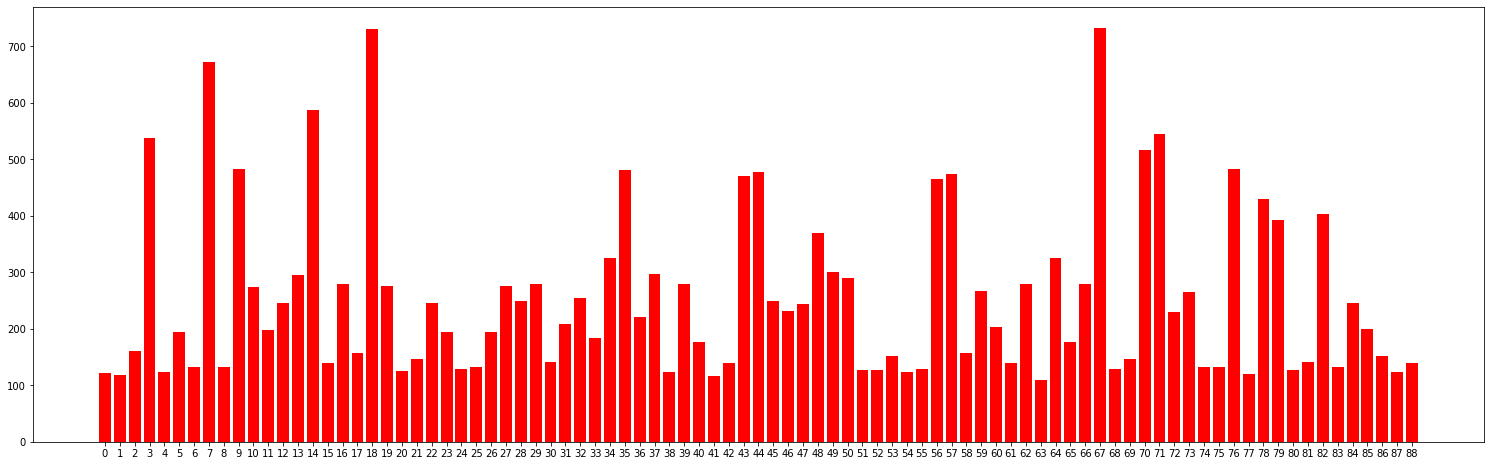

In [8]:
count_total={}
for index,i in enumerate(range(0,89,1)):
    count_total[str(index)]=load_itk_image(lstFilesDCM[i])[0].shape[0]
plt.figure(figsize=(26,8))
plt.bar(count_total.keys(), count_total.values(),  color='r')

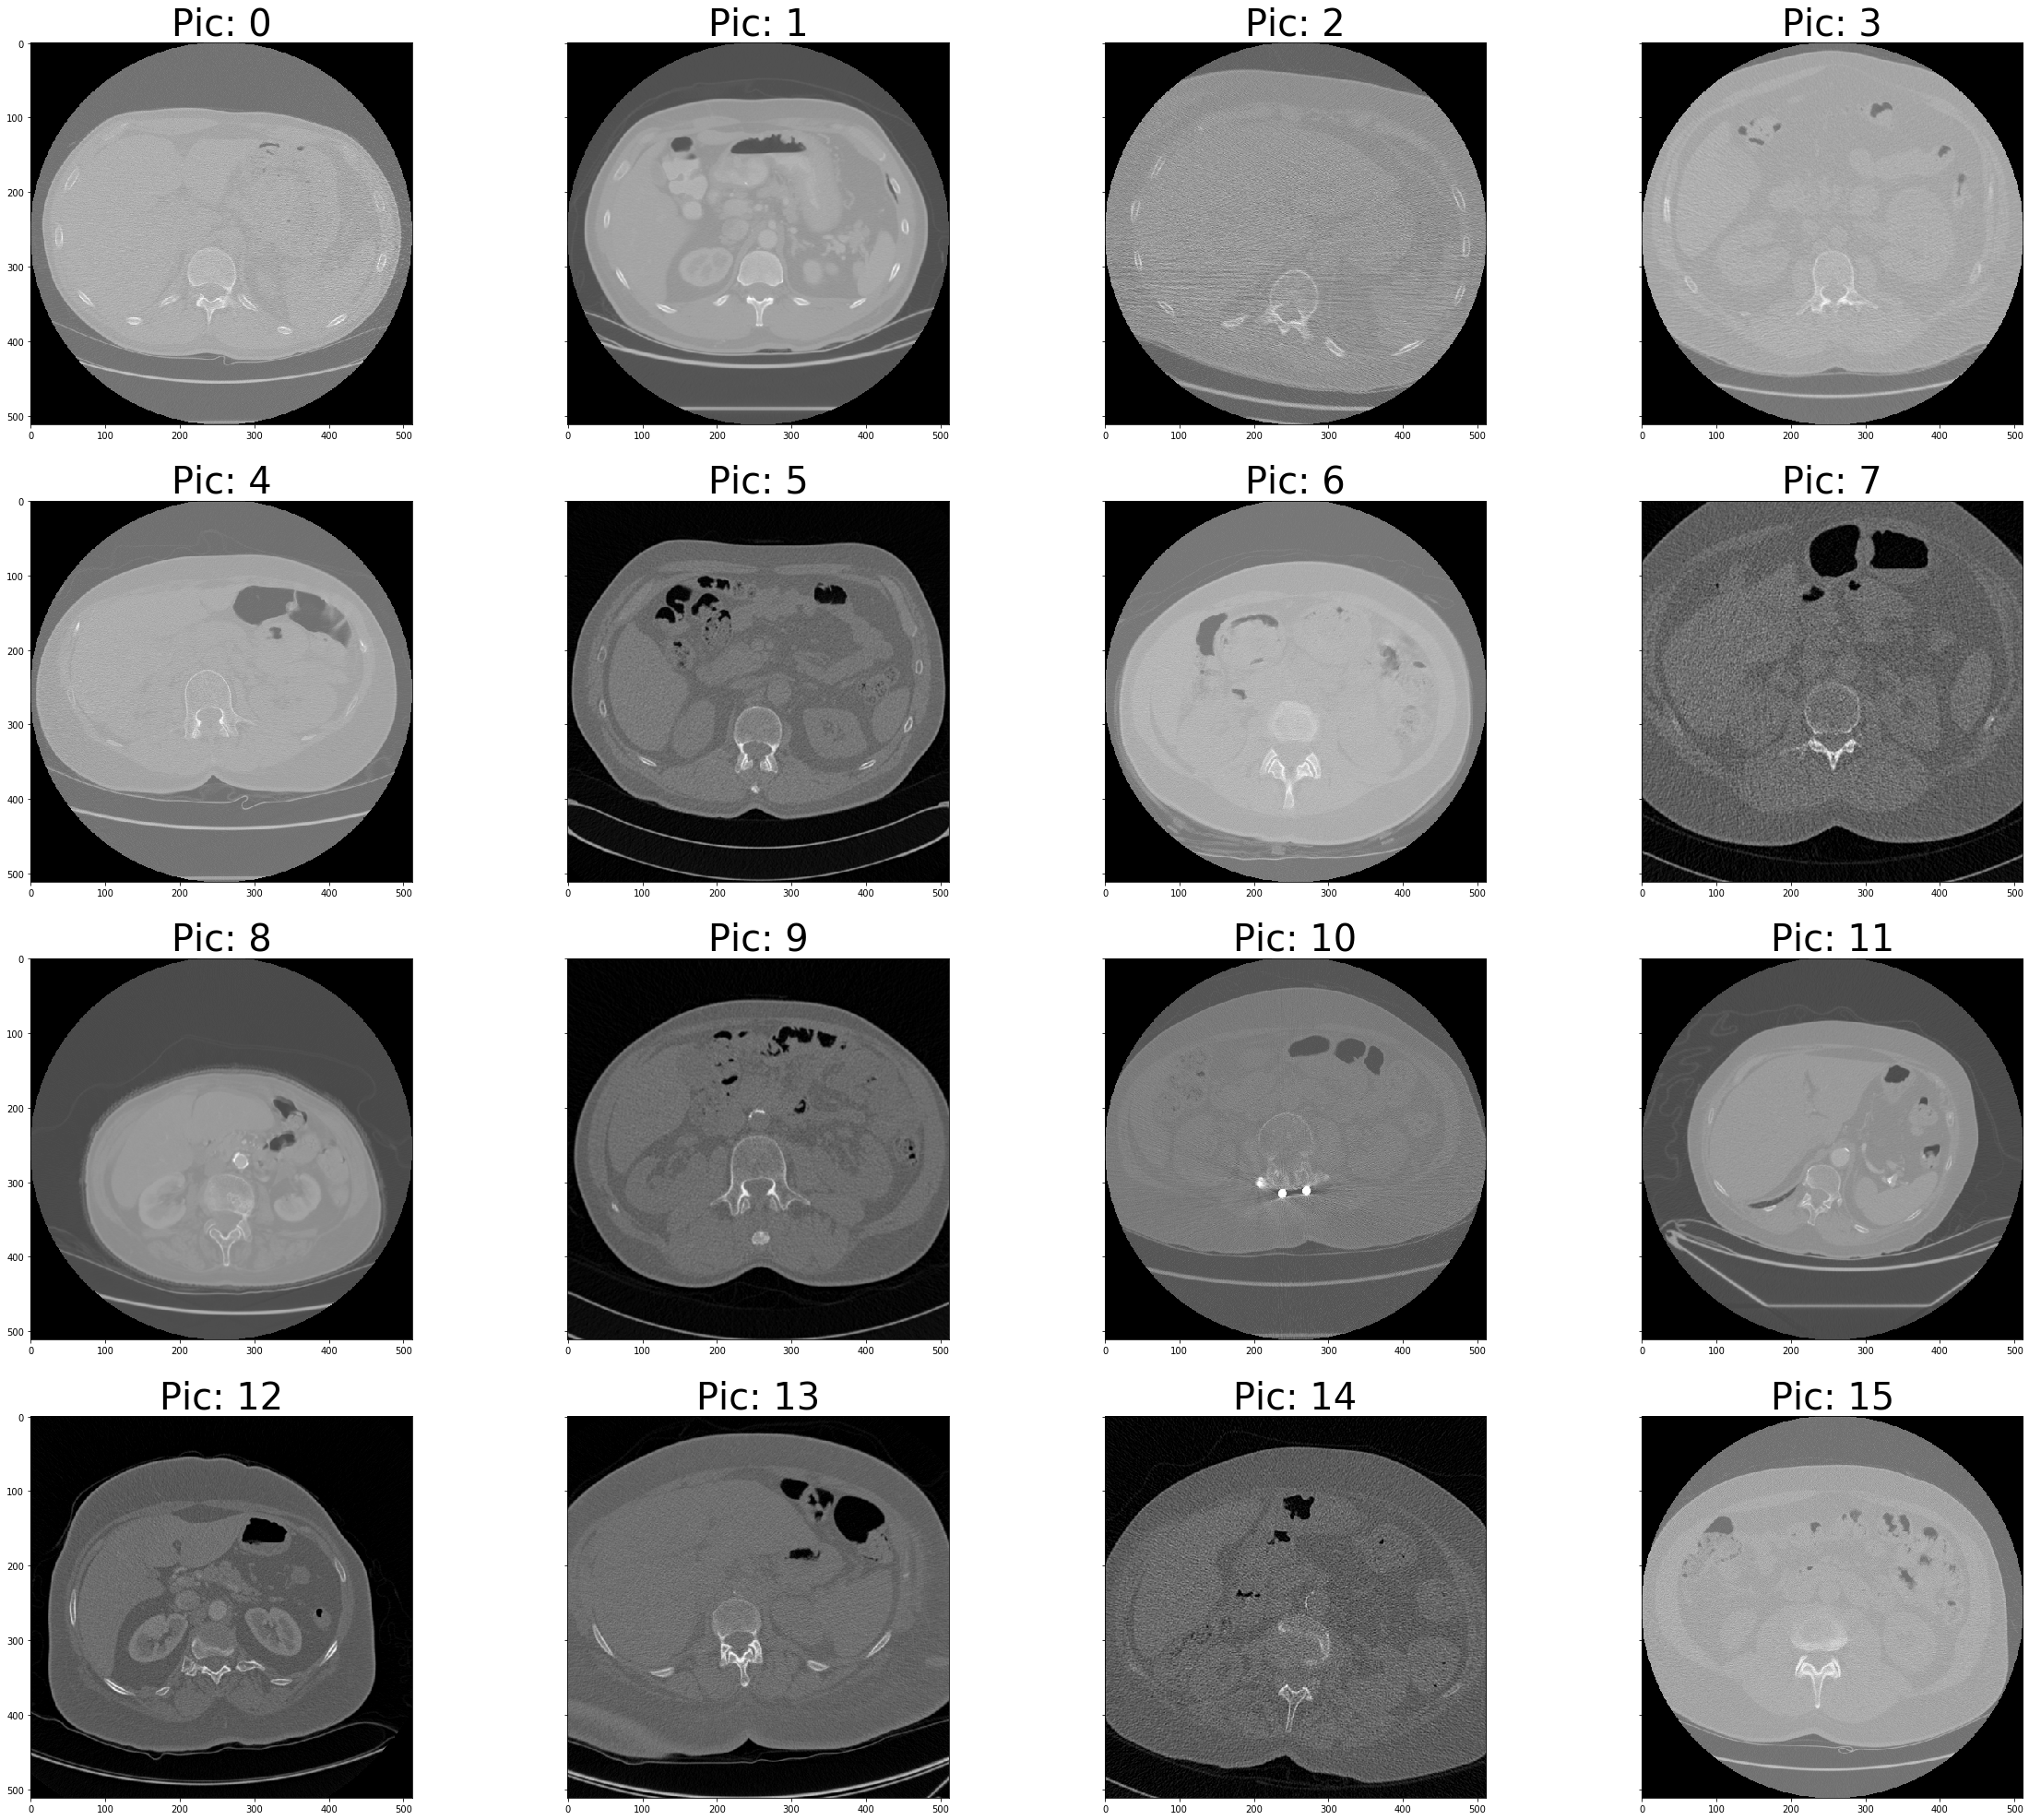

In [32]:
#   print first 16 CT pic
fig, axs = plt.subplots(4,4, figsize=(40, 35), sharey='row')
axs = axs.ravel()
for index, i in enumerate(range(0,16,1)):
    axs[index].imshow(load_itk_image(lstFilesDCM[i])[0][0])
    axs[index].set_title('Pic: '+str(i),fontsize=40)
plt.show()

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


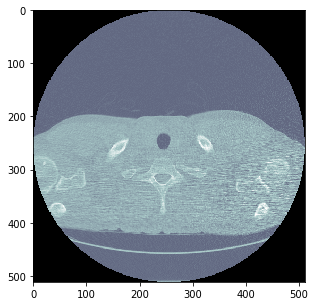

In [36]:
#  Print GIF of a CT pic
import matplotlib.animation as animation
def animate():
    fig =  plt.figure(figsize=(8,5))
    anim = plt.imshow(load_itk_image(lstFilesDCM[0])[0][0], cmap=plt.cm.bone)
    def update(i):
        anim.set_array(load_itk_image(lstFilesDCM[0])[0][i])
        return anim
    a= animation.FuncAnimation(fig, update, frames=np.arange(0, 121), interval=121)
    a.save('test.gif', writer='imagemagick', fps=15)
animate()
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))
display_gif('test.gif')

# plt.close

### Load candidates_V2 .csv

In [9]:
df_candidates = pd.read_csv('candidates_V2.csv')

In [10]:
df_candidates.head()

seriesuid     coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  68.420000  -74.480000   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -95.209361  -91.809406   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -24.766755 -120.379294   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -63.080000  -65.740000   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  52.946688  -92.688873   

       coordZ  class  
0 -288.700000      0  
1 -377.426350      0  
2 -273.361539      0  
3 -344.240000      0  
4 -241.067872      0

In [11]:
df_candidates.shape

(754975, 5)

In [61]:
datasub0 = df_candidates[0:0]
# datasub0

In [ ]:
# len(lstFilesDCM)

In [56]:
lstFilesDCM[5]


'./subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd'

In [62]:
for i in range(df_candidates.shape[0]):
#     print(i)
#      print("./subset0\\\\"+ df_candidates.seriesuid[i]+'.mhd')
    if ( './subset0\\'+ df_candidates.seriesuid[i]+ '.mhd' in lstFilesDCM ) :
#         print("./subset0\\\\"+ df_candidates.seriesuid[i]+'.mhd')
        datasub0 = datasub0.append(df_candidates.loc[i])

In [63]:
datasub0

seriesuid      coordX  \
11673   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  -66.383107   
11674   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031... -132.856859   
11675   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...   84.770000   
11676   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  134.805360   
11677   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  -87.092676   
...                                                   ...         ...   
751913  1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707...  -65.920000   
751914  1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707...  124.500000   
751915  1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707...  -12.710000   
751916  1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707...  -39.674453   
751917  1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707...  -36.390000   

           coordY      coordZ  class  
11673   57.143607  -60.885862      0  
11674   23.813034 -274.350845      0  
11675   66.170000 -249.880000      0  
11676   29.696241 -268.116009      0  
11677   41.722383 -208.831394      0  
...           ...         ...    ...  
751913 -11.600000 -101.910000      0  
751914  75.070000 -186.240000      0  
751915  13.160000  -11.290000      0  
751916  -0.628389 -139.510856      0  
751917  25.350000  -12.100000      0  

[79135 rows x 5 columns]

In [66]:
datasub0['class'].value_counts()

0    78997
1      138
Name: class, dtype: int64

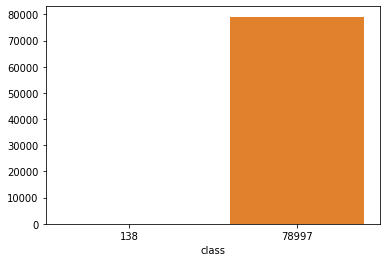

In [67]:
sns.barplot(x=datasub0['class'].value_counts(), y=datasub0['class'].value_counts().sum())

#### Make positive cancer dataframe

In [64]:
datasub0_p = datasub0[ datasub0['class'] == 1 ]

In [65]:
datasub0_p

seriesuid      coordX  \
20384   1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896... -100.709660   
22033   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   36.577828   
22208   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   45.517008   
25892   1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  136.297029   
56764   1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...  146.239444   
...                                                   ...         ...   
726438  1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028...  -42.265000   
728007  1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588...  103.710144   
728104  1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588...  110.830000   
728857  1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588...  108.537180   
751644  1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707... -102.850463   

            coordY      coordZ  class  
20384    68.191806 -230.920000      1  
22033    77.166931 -123.632500      1  
22208    48.789231 -109.205277      1  
25892   117.290290 -182.063909      1  
56764  -161.190112 -310.777295      1  
...            ...         ...    ...  
726438   92.300000 -566.640000      1  
728007   42.348020 -119.266765      1  
728104   57.690000 -122.430000      1  
728857   48.248923 -120.765895      1  
751644   57.852958 -124.742760      1  

[138 rows x 5 columns]

In [68]:
# datasub0_p.seriesuid.value_counts()

In [219]:
len(datasub0_p.seriesuid.value_counts())

55

In [69]:
def plot_nodule(row):
    itk_img = sitk.ReadImage("./subset0/"+row['seriesuid']+".mhd") 
    img_array = sitk.GetArrayFromImage(itk_img)  # z,y,x ordering
    origin_xyz = np.array(itk_img.GetOrigin())   # x,y,z  Origin in world coordinates (mm)
    spacing_xyz = np.array(itk_img.GetSpacing()) # spacing of voxels in world coor. (mm)
    center_xyz = (row['coordX'],row['coordY'], row['coordZ'])
    nodule_xyz = ((center_xyz - origin_xyz) // spacing_xyz).astype(np.int16)

    import matplotlib.patches as patches
    fig, ax = plt.subplots(1)
    ax.imshow(img_array[nodule_xyz[2]], cmap=plt.cm.gray)
    ax.add_patch(patches.Rectangle(
            (nodule_xyz[0] - 16, nodule_xyz[1]-16),   # (x,y)
            32,          # width
            32,          # height
            linewidth=1, edgecolor='r', facecolor='none'
        )
    )
    return row

In [99]:
# t= datasub0_p.seriesuid.loc[0:0]
# print(datasub0_p.iloc[0,0:1])

In [70]:
df_plot_nodule = datasub0_p[9:10]
df_plot_nodule

seriesuid  coordX  coordY  \
85487  1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583...  -86.05   16.82   

       coordZ  class  
85487  -68.38      1

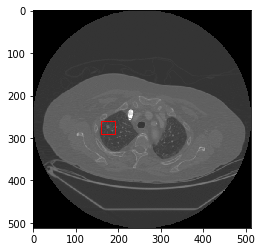

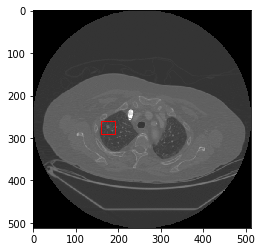

In [71]:
df_plot_nodule = df_plot_nodule.apply(plot_nodule,axis=1)

In [220]:
datasub0_n = datasub0.drop_duplicates('seriesuid', keep='last')

In [72]:
# datasub0_n = datasub0[datasub0['class']==0].head(200)

In [193]:
# datasub0_n2 = datasub0[datasub0['class']==0].head(200).groupby('seriesuid').head(200)

In [221]:
len(datasub0_n.seriesuid.value_counts())

75

In [222]:
data = datasub0_p.append(datasub0_n)

In [223]:
data.shape

(184, 5)

In [224]:
data

seriesuid      coordX  \
20384   1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896... -100.709660   
22033   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   36.577828   
22208   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   45.517008   
25892   1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  136.297029   
56764   1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...  146.239444   
...                                                   ...         ...   
632921  1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993...   63.980000   
634077  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256...  109.070000   
634788  1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500...   53.241645   
640880  1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011...   41.957463   
641332  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786... -103.002871   

            coordY      coordZ  class  
20384    68.191806 -230.920000      1  
22033    77.166931 -123.632500      1  
22208    48.789231 -109.205277      1  
25892   117.290290 -182.063909      1  
56764  -161.190112 -310.777295      1  
...            ...         ...    ...  
632921   29.530000 -177.080000      0  
634077  -39.680000 -207.730000      0  
634788   31.488771 -157.353199      0  
640880   48.108986 -120.234968      0  
641332   38.372032 -156.612097      0  

[184 rows x 5 columns]

In [228]:
len(data.seriesuid.value_counts())

75

In [73]:
df_annotation = pd.read_csv('annotations.csv')
df_annotation.head()

seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150

In [77]:
df_annotation.seriesuid.value_counts()

1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518    12
1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588     9
                                                                    ..
1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.315770913282450940389971401304     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.652347820272212119124022644822     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.321465552859463184018938648244     1
Name: seriesuid, Length: 601, dtype: int64

> some patients have more than 1 nodule

In [71]:
# df_annotation[df_annotation['diameter_mm'] ==0 ]

In [74]:
# df_annotation.isnull().sum()/len(df_annotation)*100

In [158]:
# data = data.reindex(columns=['seriesuid', 'coordX', 'coordY', 'coordZ', 'class'])


In [229]:
# data1 = data[['seriesuid','class' ]]

In [75]:
# data1

In [76]:
# data1['coordX'] = 0
# data1['coordY'] = 0
# data1['coordZ'] = 0
# data1['diameter_mm'] = 0

In [77]:
# data1 = data1.drop_duplicates('seriesuid', keep='last')

In [276]:
# data1 = data1.reset_index(drop=True)

In [78]:
# data1

In [278]:
#  copy data from  X, Y, Z,diameter_mm from   df_annotation
def fill_Data(row):
    _seriuid = row.seriesuid
    _coordX = row.coordX
    _coordY = row.coordY
    _coordZ = row.coordZ
    _diameter_mm  = row.diameter_mm
    
    if(_coordX == 0 ) :
        print("==============================================")
        return row
#     print(_seriuid)
    for index, row1 in data1.iterrows():
        if str(_seriuid) == str(row1['seriesuid']):
            
#             row1['coordX'] = _coordX
#             row1['coordY'] = _coordY
#             row1['coordZ'] = _coordZ
#             row1['diameter_mm']  = _diameter_mm
            data1.loc[index, 'coordX'] = _coordX
            data1.loc[index, 'coordY'] = _coordY
            data1.loc[index, 'coordZ'] =  _coordZ
            data1.loc[index, 'diameter_mm'] = _diameter_mm
            break
    return row

In [279]:
df_annotation = df_annotation.apply(fill_Data, axis=1)

In [79]:
# data1[data1['coordX'] > 0]

In [80]:
# df_annotation[df_annotation['seriesuid'] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547'] 

In [81]:
# data1[data1['coordX'] == 0]

# MASK EXTRACTION

In [82]:
def make_mask(center,diam,z,width,height,spacing,origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [83]:
#Some helper functions



def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))

In [6]:
#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)

In [10]:
try:
    from tqdm import tqdm # long waits are not fun
except:
    print('TQDM does make much nicer wait bars...')
    tqdm = lambda x: x

In [97]:



# Getting list of image files

luna_path = "/"
luna_subset_path = "./subset0/" 
output_path = "./ouput"

if not os.path.isdir(output_path):
    os.makedirs(output_path)



file_list=glob(luna_subset_path+"*.mhd")
# The locations of the nodes
df_node = pd.read_csv("annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()
#
# Looping over the image files
#
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        # load the data once
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            # just keep 3 slices
            imgs = np.ndarray([3,height,width],dtype=np.float32)
            masks = np.ndarray([3,height,width],dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])   # nodule center
            print("img:" , imgs,"masks:" ,masks,"center:" ,center)
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            print("v_center:",v_center )
            for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                             int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2], width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
            print("mask:",mask )

            np.save(os.path.join(output_path,"images_%04d_%04d.npy" % (fcount, node_idx)),imgs)
            np.save(os.path.join(output_path,"masks_%04d_%04d.npy" % (fcount, node_idx)),masks)

  2%|▏         | 2/89 [00:00<00:08,  9.76it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[ 80   1  32 ...   1   0   0]
  [176  72  54 ...   1   0   0]
  [176  65  54 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]


  3%|▎         | 3/89 [00:00<00:20,  4.20it/s]

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0

  4%|▍         | 4/89 [00:01<00:38,  2.22it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

  7%|▋         | 6/89 [00:02<00:31,  2.65it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

  9%|▉         | 8/89 [00:03<00:34,  2.35it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 10%|█         | 9/89 [00:03<00:31,  2.52it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 11%|█         | 10/89 [00:04<00:40,  1.93it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 12%|█▏        | 11/89 [00:04<00:39,  1.95it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 13%|█▎        | 12/89 [00:05<00:39,  1.95it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 15%|█▍        | 13/89 [00:05<00:40,  1.86it/s]

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


 16%|█▌        | 14/89 [00:06<00:39,  1.88it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 17%|█▋        | 15/89 [00:07<00:49,  1.49it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 19%|█▉        | 17/89 [00:07<00:39,  1.83it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 22%|██▏       | 20/89 [00:08<00:30,  2.28it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 24%|██▎       | 21/89 [00:08<00:30,  2.27it/s]

mask: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


 25%|██▍       | 22/89 [00:09<00:26,  2.48it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 27%|██▋       | 24/89 [00:10<00:28,  2.30it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 29%|██▉       | 26/89 [00:10<00:22,  2.85it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 31%|███▏      | 28/89 [00:11<00:20,  2.92it/s]

mask: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


 33%|███▎      | 29/89 [00:11<00:22,  2.63it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 34%|███▎      | 30/89 [00:12<00:25,  2.27it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 35%|███▍      | 31/89 [00:12<00:25,  2.25it/s]

mask: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


 36%|███▌      | 32/89 [00:13<00:25,  2.23it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 39%|███▉      | 35/89 [00:13<00:19,  2.71it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 43%|████▎     | 38/89 [00:15<00:23,  2.15it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 45%|████▍     | 40/89 [00:15<00:19,  2.51it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 46%|████▌     | 41/89 [00:16<00:19,  2.44it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 49%|████▉     | 44/89 [00:16<00:16,  2.71it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 51%|█████     | 45/89 [00:17<00:23,  1.91it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 53%|█████▎    | 47/89 [00:18<00:22,  1.87it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 54%|█████▍    | 48/89 [00:19<00:25,  1.62it/s]

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


 56%|█████▌    | 50/89 [00:20<00:20,  1.94it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 57%|█████▋    | 51/89 [00:21<00:21,  1.77it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 58%|█████▊    | 52/89 [00:21<00:18,  2.03it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 62%|██████▏   | 55/89 [00:21<00:12,  2.63it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 63%|██████▎   | 56/89 [00:21<00:11,  2.82it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 64%|██████▍   | 57/89 [00:22<00:16,  1.89it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 65%|██████▌   | 58/89 [00:23<00:20,  1.54it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 66%|██████▋   | 59/89 [00:24<00:17,  1.75it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 67%|██████▋   | 60/89 [00:24<00:17,  1.69it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 70%|██████▉   | 62/89 [00:25<00:12,  2.15it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 71%|███████   | 63/89 [00:25<00:14,  1.80it/s]

mask: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0 

 72%|███████▏  | 64/89 [00:26<00:11,  2.15it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 74%|███████▍  | 66/89 [00:26<00:08,  2.62it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 75%|███████▌  | 67/89 [00:27<00:09,  2.25it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 78%|███████▊  | 69/89 [00:29<00:12,  1.57it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 79%|███████▊  | 70/89 [00:29<00:11,  1.60it/s]

mask: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0 

 80%|███████▉  | 71/89 [00:30<00:12,  1.42it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 81%|████████  | 72/89 [00:31<00:13,  1.22it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 82%|████████▏ | 73/89 [00:32<00:11,  1.37it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 84%|████████▍ | 75/89 [00:32<00:07,  1.82it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 85%|████████▌ | 76/89 [00:32<00:06,  2.13it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 87%|████████▋ | 77/89 [00:33<00:06,  1.75it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 89%|████████▉ | 79/89 [00:34<00:05,  1.95it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 90%|████████▉ | 80/89 [00:34<00:05,  1.75it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 91%|█████████ | 81/89 [00:35<00:04,  1.95it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 92%|█████████▏| 82/89 [00:35<00:03,  2.13it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 93%|█████████▎| 83/89 [00:36<00:03,  1.83it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 94%|█████████▍| 84/89 [00:36<00:02,  2.08it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 96%|█████████▌| 85/89 [00:37<00:01,  2.00it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 97%|█████████▋| 86/89 [00:37<00:01,  2.03it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

 98%|█████████▊| 87/89 [00:38<00:00,  2.15it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

100%|██████████| 89/89 [00:38<00:00,  2.31it/s]

img: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] masks: [[[80  1 32 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]] cent

In [98]:
mini_df

seriesuid      coordX  \
1180  1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707... -104.441975   

         coordY      coordZ  diameter_mm  \
1180  57.839428 -124.308363       7.3104   

                                                   file  
1180  ./subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.97...

(3, 512, 512)
Img min: -2048.0 Img max: 1295.0


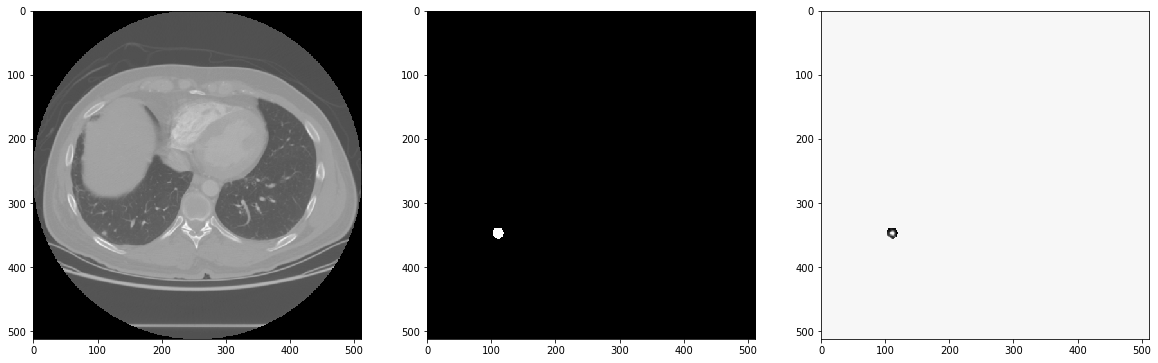

In [107]:
imgs = np.load(output_path+'/images_0001_0023.npy')
print(np.shape(imgs))
print('Img min:',imgs.min(),'Img max:',imgs.max())
# imgs[imgs==imgs.min()] = 0

masks = np.load(output_path+'/masks_0001_0023.npy')

plt.figure(figsize=[20,10])
plt.subplot(131)
plt.imshow(imgs[1][:512, :512],cmap='gray')
plt.subplot(132)
plt.imshow(masks[1][:512, :512],cmap='gray')
plt.subplot(133)
plt.imshow((imgs[1][:512, :512])*masks[1][:512, :512],cmap='gray')

# Segment lung ROI (Region of Interest)

In [21]:
# scikit-image is a collection of algorithms for image processing
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize

In [110]:
working_path = "./ouput/"
file_list=glob(working_path+"images_*.npy")

for img_file in file_list:
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64) 
    print ("on image", img_file)
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]

       #  ax[1, 1].imshow(lungmask[i], cmap='gray')
       #  plt.imshow(img,cmap = 'gray')
       # plt.show()

        #Standardize the pixel values
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std
        # plt.hist(img.flatten(), bins=200)
        #  plt.show()
        # Find the average pixel value near the lungs
        # to renormalize washed out images
        middle = img[100:400,100:400] 
        mean = np.mean(middle)  
        max_im = np.max(img)
        min_im = np.min(img)
        # To improve threshold finding, I'm moving the 
        # underflow and overflow on the pixel spectrum
        img[img==max_im]=mean
        img[img==min_im]=mean
        #
        # Using Kmeans to separate foreground (radio-opaque tissue)
        # and background (radio transparent tissue ie lungs)
        # Doing this only on the center of the image to avoid 
        # the non-tissue parts of the image as much as possible
        #
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
       # plt.imshow(thresh_img, cmap = "gray")
       # plt.show()
       # np.save(os.path.join(working_path, "thresh_%d.npy" )% i, thresh_img)
        #
        # I found an initial erosion helful for removing graininess from some of the regions
        # and then large dialation is used to make the lung region 
        # engulf the vessels and incursions into the lung cavity by 
        # radio opaque tissue
        #
       # plt.imshow(thresh_img, cmap='gray')
       # plt.show()
       # plt.imshow(thresh_img, cmap='gray')
       # plt.show()

        eroded = morphology.erosion(thresh_img,np.ones([4,4]))
       # plt.imshow(eroded, cmap='gray')
       # plt.show()
        dilation = morphology.dilation(eroded,np.ones([10,10]))
      #  plt.imshow(dilation, cmap='gray')
       # plt.show()
        #
        #  Label each region and obtain the region properties
        #  The background region is removed by removing regions 
        #  with a bbox that is to large in either dimnsion
        #  Also, the lungs are generally far away from the top 
        #  and bottom of the image, so any regions that are too
        #  close to the top and bottom are removed
        #  This does not produce a perfect segmentation of the lungs
        #  from the image, but it is surprisingly good considering its
        #  simplicity. 
        #
        labels = measure.label(dilation)
        label_vals = np.unique(labels)
       # plt.imshow(labels)
      #  plt.show()

        regions = measure.regionprops(labels)
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>50 and B[2]<472:
                good_labels.append(prop.label)
        mask = np.ndarray([512,512],dtype=np.int8)
        mask[:] = 0
        #
        #  The mask here is the mask for the lungs--not the nodes
        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask
        #
        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
       # plt.imshow(mask, cmap='gray')
       # plt.show()
        imgs_to_process[i] = mask
    np.save(img_file.replace("images","lungmask"),imgs_to_process)
#
#    Here we're applying the masks and cropping and resizing the image
#

file_list=glob(working_path+"lungmask_*.npy")
out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks
for fname in file_list:
    print ("working on file ", fname)
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        node_mask = node_masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img= mask*img          # apply lung mask
        #
        # renormalizing the masked image (in the mask region)
        #
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
        img = img-new_mean
        img = img/new_std
        np.save(os.path.join(working_path, "ROI_%d.npy") % i, img)
       # plt.imshow(img, cmap='gray')
       #plt.show()
        #make image bounding box  (min row, min col, max row, max col)

on image ./ouput\images_0001_0023.npy
on image ./ouput\images_0002_0025.npy
on image ./ouput\images_0002_0026.npy
on image ./ouput\images_0003_0028.npy
on image ./ouput\images_0005_0086.npy
on image ./ouput\images_0007_0098.npy
on image ./ouput\images_0008_0103.npy
on image ./ouput\images_0009_0110.npy
on image ./ouput\images_0010_0117.npy
on image ./ouput\images_0011_0129.npy
on image ./ouput\images_0011_0130.npy
on image ./ouput\images_0011_0131.npy
on image ./ouput\images_0011_0132.npy
on image ./ouput\images_0012_0135.npy
on image ./ouput\images_0012_0136.npy
on image ./ouput\images_0013_0139.npy
on image ./ouput\images_0014_0144.npy
on image ./ouput\images_0016_0149.npy
on image ./ouput\images_0019_0199.npy
on image ./ouput\images_0020_0335.npy
on image ./ouput\images_0020_0336.npy
on image ./ouput\images_0021_0344.npy
on image ./ouput\images_0021_0345.npy
on image ./ouput\images_0022_0347.npy
on image ./ouput\images_0022_0348.npy
on image ./ouput\images_0022_0349.npy
on image ./o

working on file  ./ouput\lungmask_0071_1017.npy
working on file  ./ouput\lungmask_0071_1018.npy
working on file  ./ouput\lungmask_0071_1019.npy
working on file  ./ouput\lungmask_0072_1020.npy
working on file  ./ouput\lungmask_0072_1021.npy
working on file  ./ouput\lungmask_0072_1022.npy
working on file  ./ouput\lungmask_0074_1030.npy
working on file  ./ouput\lungmask_0075_1049.npy
working on file  ./ouput\lungmask_0076_1054.npy
working on file  ./ouput\lungmask_0078_1072.npy
working on file  ./ouput\lungmask_0079_1073.npy
working on file  ./ouput\lungmask_0079_1074.npy
working on file  ./ouput\lungmask_0080_1084.npy
working on file  ./ouput\lungmask_0081_1106.npy
working on file  ./ouput\lungmask_0082_1108.npy
working on file  ./ouput\lungmask_0082_1109.npy
working on file  ./ouput\lungmask_0083_1116.npy
working on file  ./ouput\lungmask_0083_1117.npy
working on file  ./ouput\lungmask_0084_1123.npy
working on file  ./ouput\lungmask_0084_1124.npy
working on file  ./ouput\lungmask_0084_1

# Visualise nodule 

c:\python\python37\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\python\python37\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\python\python37\lib\site-packages\ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new

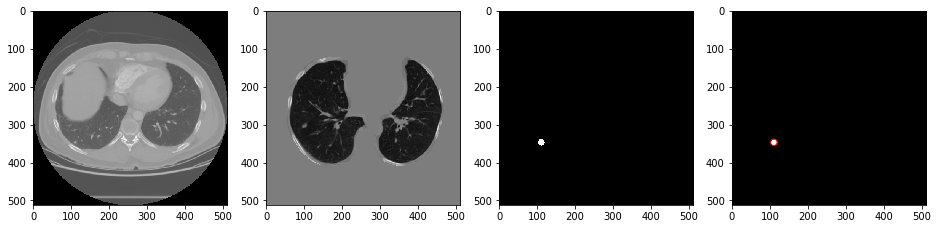

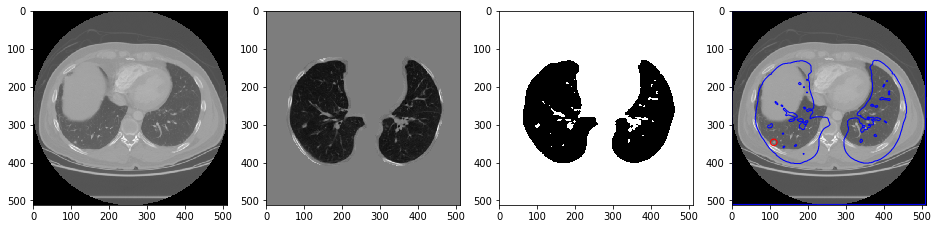

In [113]:
from scipy import ndimage

working_path = "./ouput/"
image0 = np.load(working_path+'images_0001_0023.npy')
im = np.load(working_path+'ROI_1.npy')
image = np.load(working_path+'masks_0001_0023.npy')
image1 = image[1]
l = 512
plt.figure(figsize=(16, 5))
plt.subplot(141)
plt.imshow(image0[1][:l, :l], cmap=plt.cm.gray)
plt.subplot(142)
plt.imshow(im[:l, :l], cmap=plt.cm.gray)
plt.subplot(143)
plt.imshow(image[1][:l, :l], cmap=plt.cm.gray)
plt.subplot(144)
plt.imshow(image[1][:l, :l], cmap=plt.cm.gray)
plt.subplot(144)
plt.contour(image1[:l, :l], [0.5], linewidths=1, colors='r')
#plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)

binary_img = im > 0.5


# array([[0, 0, 0, 0, 0],
#        [0, 1, 1, 1, 0],
#        [0, 1, 1, 1, 0],
#        [0, 1, 1, 1, 0],
#        [0, 0, 0, 0, 1]])
# >>> # Opening removes small objects
# >>> ndimage.binary_opening(a, structure=np.ones((3,3))).astype(int)
# array([[0, 0, 0, 0, 0],
#        [0, 1, 1, 1, 0],
#        [0, 1, 1, 1, 0],
#        [0, 1, 1, 1, 0],
#        [0, 0, 0, 0, 0]])


# Remove small white regions
open_img = ndimage.binary_opening(binary_img)
# Remove small black hole
close_img = ndimage.binary_closing(open_img)
final = close_img
plt.figure(figsize=(16, 5))

plt.subplot(141)
plt.imshow(image0[1][:l, :l], cmap=plt.cm.gray)
plt.subplot(142)
plt.imshow(im[:l, :l], cmap=plt.cm.gray)
plt.subplot(143)
plt.imshow(close_img[:l, :l], cmap=plt.cm.gray)
plt.subplot(144)
#plt.imshow(mask[:l, :l], cmap=plt.cm.gray)
plt.contour(final[:l, :l], [0.5], linewidths=1, colors='b')
plt.subplot(144)
#plt.imshow(mask[:l, :l], cmap=plt.cm.gray)
plt.contour(image1[:l, :l], [0.5], linewidths=1, colors='r')
plt.subplot(144)
#plt.imshow(mask[:l, :l], cmap=plt.cm.gray)
plt.imshow(image0[1][:l, :l], cmap=plt.cm.gray)
#plt.subplts_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
#plt.imshow(mask[:l, :l], cmap=plt.cm.gray)
plt.imshow(image0[1][:l, :l], cmap=plt.cm.gray)

plt.show()


# Build training  image dataset

In [33]:
from skimage.transform import resize
import skimage.transform as st

In [47]:
new_spacing = [1,1,1]
# Getting list of image files

luna_path = "/"
luna_subset_path = "./subset0/" 
output_path = "./data2"

tr_output_img_path_1="./data2/train/1"
tr_output_img_path_0="./data2/train/0"

if not os.path.isdir(tr_output_img_path_1):
    os.makedirs(tr_output_img_path_1)
    
if not os.path.isdir(tr_output_img_path_0):
    os.makedirs(tr_output_img_path_0)


file_list=glob(luna_subset_path+"*.mhd")
# The locations of the nodes
df_node = pd.read_csv("annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()
#
# Looping over the image files
#
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
     # load the data once
    itk_img = sitk.ReadImage(img_file) 
    img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
    num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
    origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
#     imgs = img_array[0:64][64:-64 ][64:-64 ]
#     imgs =  st.resize(imgs, (64, 64,64))
    resampled_img = sitk.Resample(itk_img, [64, 64, 64], sitk.Transform(),
    sitk.sitkNearestNeighbor, itk_img.GetOrigin(), new_spacing,
                                  itk_img.GetDirection(), 0.0, itk_img.GetPixelID())
    new_img_array = sitk.GetArrayFromImage(resampled_img)
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those        
        
        np.save(os.path.join(tr_output_img_path_1,"images_%04d.npy" % (fcount)),new_img_array)
    else :
        np.save(os.path.join(tr_output_img_path_0,"images_%04d.npy" % (fcount)),new_img_array)
        
        
        
        
        

100%|██████████| 89/89 [00:33<00:00,  2.62it/s]


In [46]:
new_img_array.shape

(64, 64, 64)

In [18]:
def plot_3d(image, floor=-700):
    # Floor: lowest DU that will be visible
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, floor)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

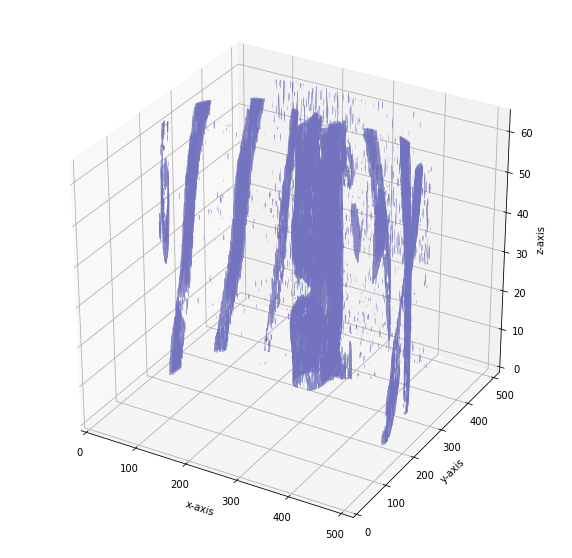

In [206]:
pic = np.load('./data/train/1/images_0003_1180.npy')
plot_3d(pic,400)
plt.show()



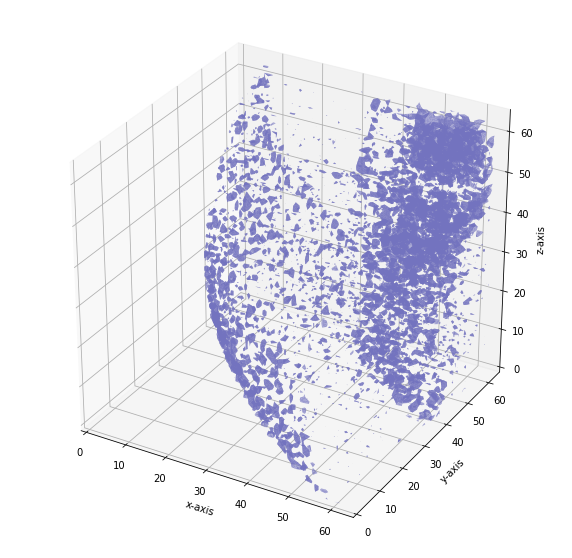

In [50]:
pic = np.load(tr_output_img_path_1+'/images_0007.npy')
plot_3d(pic,100)
plt.show()

In [51]:
_imgs_0  = []
_labels_0= []
_imgs_1  = []
_labels_1= []
for folder in glob("./data2/train/*"):
    for file in glob(os.path.join(folder,"*.npy")):
#         print(folder)
        if folder == "./data2/train\\0":
            _imgs_0.append(np.load(file))
            _labels_0.append(0)
        elif folder == "./data2/train\\1":
            _imgs_1.append(np.load(file))
            _labels_1.append(1)

In [52]:
_imgs = _imgs_0+ _imgs_1
_labels = _labels_0 + _labels_1
print(len(_imgs),len(_labels))

70 70


In [53]:
from sklearn.utils import shuffle
_imgs, _labels = shuffle(_imgs, _labels)

In [54]:
img = np.array(_imgs)
img.shape

(70, 64, 64, 64)

In [55]:
labels = np.array(_labels)
labels.shape

(70,)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(img, labels, test_size=0.2, random_state=12)
y_test_original = y_test

In [57]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,Activation
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.layers import Conv3D,MaxPool3D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.optimizers import SGD
from keras import backend as K
from keras import regularizers


Using TensorFlow backend.


In [58]:
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [59]:
# y_train1

In [60]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [61]:
X_train[1].shape

(64, 64, 64)

In [51]:
## iterate in train and test, add the rgb dimention 
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array

In [62]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3])
X_test  = X_test.reshape(X_test.shape[0],1, X_test.shape[1], X_test.shape[2],X_test.shape[3])

In [63]:
def model(input_shape = (64, 512, 512)):
#     classifier = Sequential()
#     classifier.add(Conv2D(32, (3, 3), input_shape = input_shape, padding='same', use_bias=False))
#     classifier.add(BatchNormalization())
#     classifier.add(Activation('relu'))
#     classifier.add(Conv2D(32, (3, 3), use_bias=False))
#     classifier.add(BatchNormalization())
#     classifier.add(Activation('relu'))
#     classifier.add(MaxPooling2D(pool_size = (2, 2)))
#     classifier.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
#     classifier.add(BatchNormalization())
#     classifier.add(Activation('relu'))
#     classifier.add(Conv2D(32, (3, 3), use_bias=False))
#     classifier.add(BatchNormalization())
#     classifier.add(Activation('relu'))
#     classifier.add(MaxPooling2D(pool_size = (2, 2)))
#     classifier.add(Flatten())
#     classifier.add(Dense(units = 256, kernel_initializer='he_normal', use_bias=False))
#     classifier.add(BatchNormalization())
#     classifier.add(Activation('relu'))
#     classifier.add(Dropout(0.25))
#     classifier.add(Dense(units = 2, activation = 'softmax', kernel_initializer='he_normal'))
#     classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#     return classifier
    ## input layer
#     input_layer = Input((64, 512, 512, 1))

#     ## convolutional layers
#     conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
#     conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

#     ## add max pooling to obtain the most imformatic features
#     pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

#     conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
#     conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
#     pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

#     ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
#     pooling_layer2 = BatchNormalization()(pooling_layer2)
#     flatten_layer = Flatten()(pooling_layer2)

#     ## create an MLP architecture with dense layers : 4096 -> 512 -> 10
#     ## add dropouts to avoid overfitting / perform regularization
#     dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
#     dense_layer1 = Dropout(0.4)(dense_layer1)
#     dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
#     dense_layer2 = Dropout(0.4)(dense_layer2)
#     output_layer = Dense(units=2, activation='softmax')(dense_layer2)

#     ## define the model with input layer and output layer
#     model = Model(inputs=input_layer, outputs=output_layer)
#     model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])
#     return model
#     model = Sequential()

#     model.add(Convolution3D(
#         32,
#         kernel_dim1=64, # depth
#         kernel_dim2=64, # rows
#         kernel_dim3=64, # cols
#         input_shape=(64, 512, 512,1),
#         activation='relu'
#     ))
#     model.add(MaxPooling3D(pool_size=(3,3,3),data_format='channels_first'))

#     model.add(MaxPooling3D(pool_size=(3, 3, 3)))

#     model.add(Dropout(0.5))

#     model.add(Flatten())

#     model.add(Dense(128, init='normal', activation='relu'))

#     model.add(Dropout(0.5))

#     model.add(Dense(2,init='normal'))

#     model.add(Activation('softmax'))

#     model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])
#     return model

    model=Sequential()

    model.add(Conv3D(32,  #No. of filters   
                    (6,6,6),  #kernel size
                    input_shape=(1,64,64,64),
                    data_format='channels_first',
                    strides=2,
                    padding='same',
                    use_bias=False,
                    kernel_regularizer=regularizers.l2(0.01), 
                    kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(3,3,3),strides=2,data_format='channels_first'))

    model.add(Conv3D(64,      
                    (5,5,5),
                    data_format='channels_first',
                    strides=1,
                    padding='same',
                    use_bias=False,
                    kernel_regularizer=regularizers.l2(0.01), 
                    kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(3,3,3),strides=2,data_format='channels_first'))

    model.add(Conv3D(96,      
                    (3,3,3),
                    data_format='channels_first',
                    strides=1,
                    padding='same',
                    use_bias=False,
                    kernel_regularizer=regularizers.l2(0.01), 
                    kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv3D(128,      
                    (3,3,3),
                    data_format='channels_first',
                    strides=2,
                    padding='same',
                    use_bias=False,
                    kernel_regularizer=regularizers.l2(0.01), 
                    kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2),strides=2,data_format='channels_first'))

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(2,activation='softmax'))

    epochs=100
    learningRate=0.01
    decay=learningRate/epochs

    sgd = SGD(lr=learningRate,decay=decay,momentum=0.9,nesterov=False)

    model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
    return model

In [64]:
classifier = model()
classifier.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 32, 32, 32, 32)    6912      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 15, 15, 15)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 15, 15, 15)    256000    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 15, 15, 15)    60        
_________________________________________________________________
activation_2 (Activation)    (None, 64, 15, 15, 15)   

In [66]:
history = classifier.fit(x=X_train, y=y_train, batch_size=16, epochs=50,  validation_data=(X_test, y_test) ,
                           callbacks = [
                #early stopping in case the loss stops decreasing
                k.callbacks.EarlyStopping(monitor='val_loss', patience=3),
                # only save the model if the monitored quantity (val_loss or val_acc) has improved
                k.callbacks.ModelCheckpoint("fruits_checkpoints.h5", monitor='val_loss', save_best_only = True),
                # only needed for visualising with TensorBoard
                #k.callbacks.TensorBoard(log_dir = "logs/{:%d_%b_%Y_%H:%M:%S}".format(dt.now()) )
              ])

Train on 56 samples, validate on 14 samples
Epoch 1/50
56/56 [==============================] - 34s 601ms/step - loss: 3.5609 - accuracy: 0.8214 - val_loss: 4.3237 - val_accuracy: 0.6429
Epoch 2/50
56/56 [==============================] - 34s 607ms/step - loss: 3.5464 - accuracy: 0.8214 - val_loss: 4.5202 - val_accuracy: 0.6429
Epoch 3/50
56/56 [==============================] - 34s 599ms/step - loss: 3.6323 - accuracy: 0.7857 - val_loss: 5.9465 - val_accuracy: 0.6429
Epoch 4/50
56/56 [==============================] - 34s 616ms/step - loss: 3.8303 - accuracy: 0.6964 - val_loss: 7.3776 - val_accuracy: 0.6429
Epoch 5/50
56/56 [==============================] - 35s 619ms/step - loss: 3.8295 - accuracy: 0.8214 - val_loss: 5.0973 - val_accuracy: 0.6429
Epoch 6/50
56/56 [==============================] - 34s 616ms/step - loss: 3.5786 - accuracy: 0.8214 - val_loss: 3.7545 - val_accuracy: 0.3571
Epoch 7/50
56/56 [==============================] - 33s 597ms/step - loss: 3.5285 - accuracy: 0.82

In [67]:
classifier.save("cnn_model.h5")

In [68]:
predict_cnn = classifier.predict(X_test)


In [69]:
predict_cnn

array([[0.15809213, 0.8419079 ],
       [0.13597791, 0.8640221 ],
       [0.36636502, 0.633635  ],
       [0.13605182, 0.8639481 ],
       [0.36126512, 0.63873494],
       [0.33808598, 0.661914  ],
       [0.23755987, 0.76244015],
       [0.34333077, 0.65666926],
       [0.1456742 , 0.85432583],
       [0.13580294, 0.8641971 ],
       [0.33851466, 0.6614854 ],
       [0.32996127, 0.67003876],
       [0.3290143 , 0.6709857 ],
       [0.23159342, 0.7684065 ]], dtype=float32)

In [77]:
pic_val_1 = np.load('./data2/val/1/images_0075.npy')
pic_val_1 = pic_val_1.reshape(1, 1, pic_val_1.shape[0], pic_val_1.shape[1], pic_val_1.shape[2])

predict_cnn_1 = classifier.predict(pic_val_1)

In [78]:
predict_cnn_1

array([[0.23129417, 0.7687058 ]], dtype=float32)

In [73]:
# print(classification_report(y_test, predict_cnn))

In [20]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          _i16:  5.8 KiB
                         Dense:  2.0 KiB
            BatchNormalization:  2.0 KiB
                       Flatten:  1.4 KiB
                    Activation:  1.4 KiB
                  MaxPooling3D:  1.4 KiB
                     MaxPool3D:  1.4 KiB
                           SGD:  1.2 KiB
                        Axes3D:  1.0 KiB
              Poly3DCollection:  1.0 KiB


In [15]:
# del X_resample
import gc
del img
gc.collect()

122